In [ ]:
import numpy as np
import cv2
import pandas as pd
import os
import zipfile

local_zip= 'archive.zip'
zip_ref= zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('archive/seg_train')
zip_ref.close()

local_zip='archive.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('archive/seg_test')
zip_ref.close()

local_zip='archive.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('archive/seg_pred')
zip_ref.close()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
from tqdm import tqdm
def load_data():
    datasets = ['archive/seg_train/seg_train/seg_train', 'archive/seg_test/seg_test/seg_test']
    output = []

    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))

        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder),file)

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')
        output.append((images, labels))
    return output

(train_images, train_labels), (test_images, test_labels) = load_data()
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Loading archive/seg_train/seg_train/seg_train


100%|██████████| 2271/2271 [00:01<00:00, 1407.36it/s]


Loading archive/seg_test/seg_test/seg_test


100%|██████████| 474/474 [00:00<00:00, 1464.85it/s]


Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


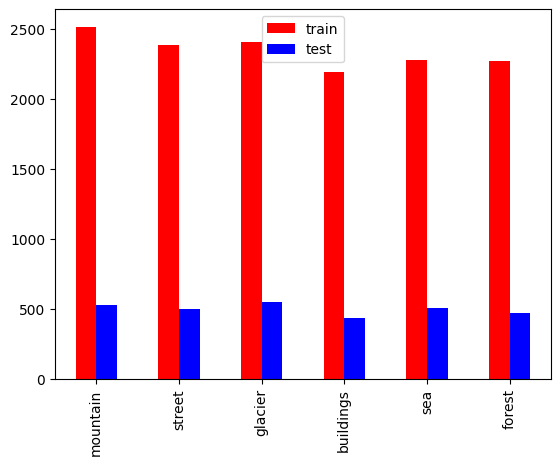

In [ ]:
import pandas as pd
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names).plot.bar(color=['red', 'blue'])
plt.show()

train_images = train_images / 255.0
test_images = test_images / 255.0

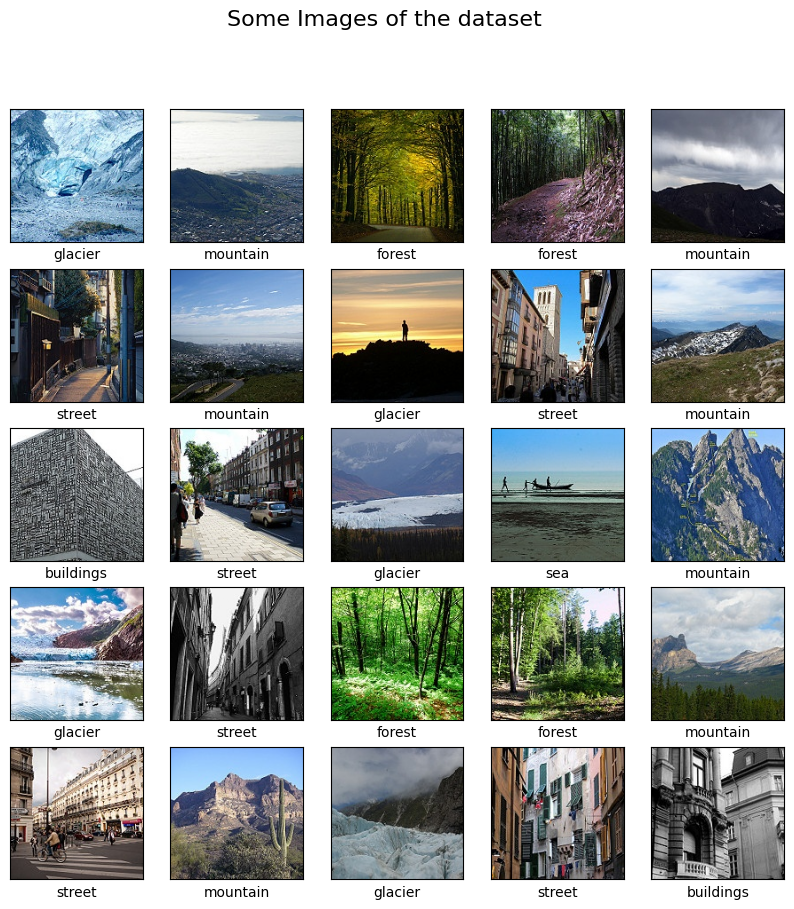

In [ ]:
def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some Images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_examples(class_names, train_images, train_labels)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 365s 4s/step - loss: 1.2088 - acc: 0.5663 - val_loss: 0.9508 - val_acc: 0.6562
Epoch 2/10
88/88 [==============================] - 359s 4s/step - loss: 0.7375 - acc: 0.7243 - val_loss: 0.6897 - val_acc: 0.7549
Epoch 3/10
88/88 [==============================] - 360s 4s/step - loss: 0.5661 - acc: 0.7969 - val_loss: 0.6842 - val_acc: 0.7595
Epoch 4/10
88/88 [==============================] - 360s 4s/step - loss: 0.4475 - acc: 0.8462 - val_loss: 0.6364 - val_acc: 0.7887
Epoch 5/10
88/88 [==============================] - 358s 4s/step - loss: 0.3232 - acc: 0.8898 - val_loss: 0.6568 - val_acc: 0.7784
Epoch 6/10
88/88 [==============================] - 360s 4s/step - loss: 0.2212 - acc: 0.9311 - val_loss: 0.6721 - val_acc: 0.7852
Epoch 7/10
88/88 [==============================] - 362s 4s/step - loss: 0.1426 - acc: 0.9599 - val_loss: 0.7025 - val_acc: 0.7891
Epoch 8/10
88/88 [==============================] - 357s 4s/step - loss: 0.0967 - a

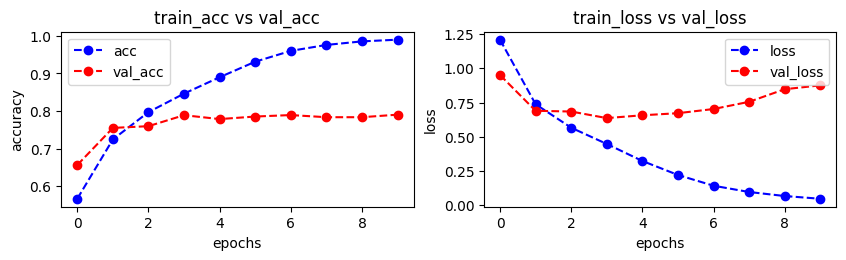

94/94 [==============================] - 23s 249ms/step - loss: 0.9201 - acc: 0.7850


In [ ]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 23s 243ms/step


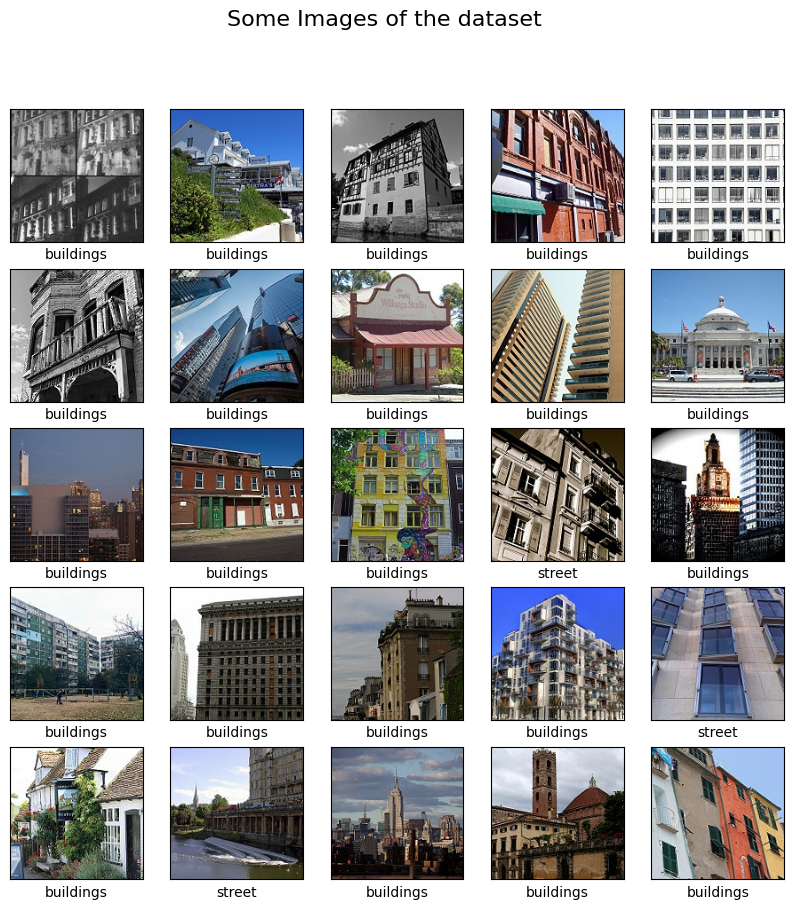

In [ ]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

display_examples(class_names, test_images, pred_labels)

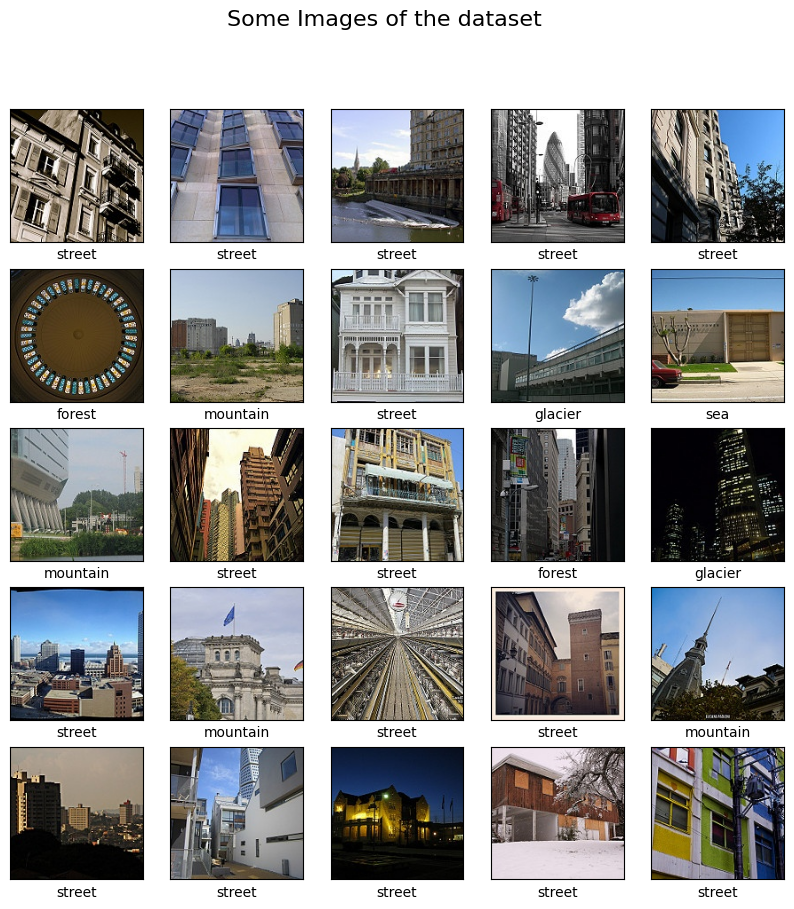

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):

    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

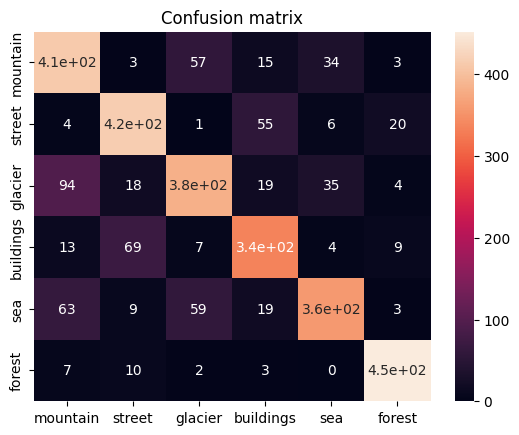

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

train_features = model.predict(train_images)
test_features = model.predict(test_images)

n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

plot_accuracy_loss(history)

test_loss = model2.evaluate(test_features, test_labels)